# 1. 序列模型

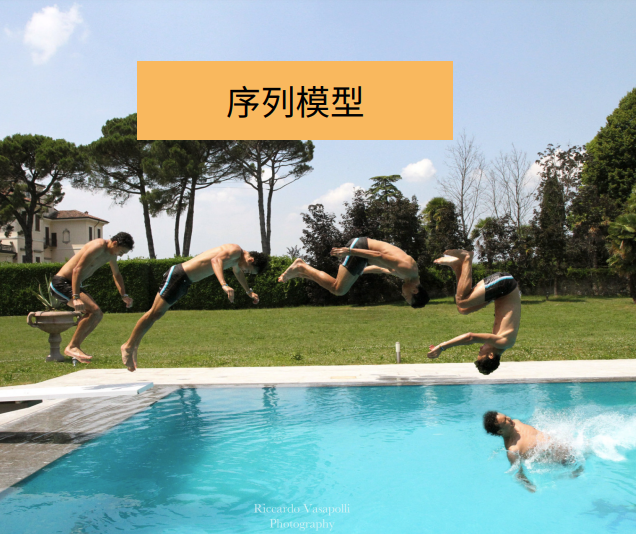

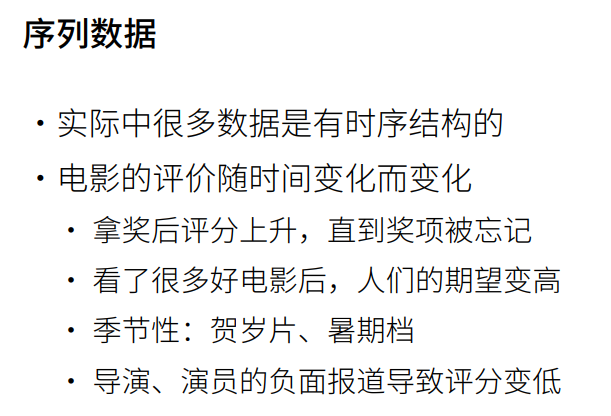

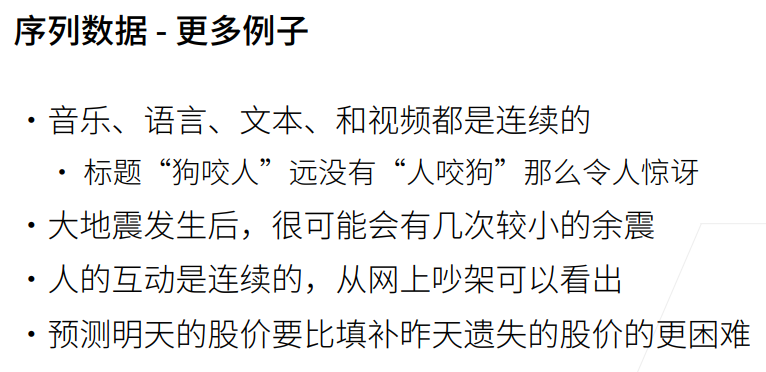

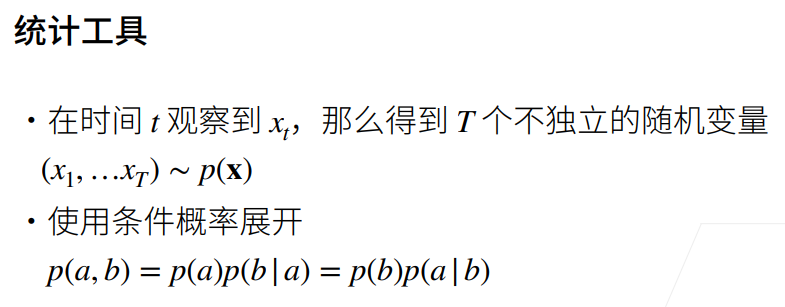

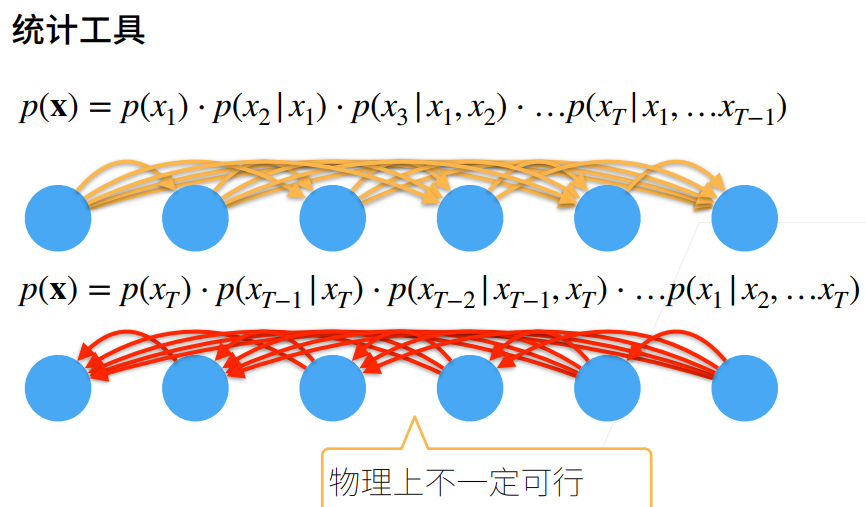

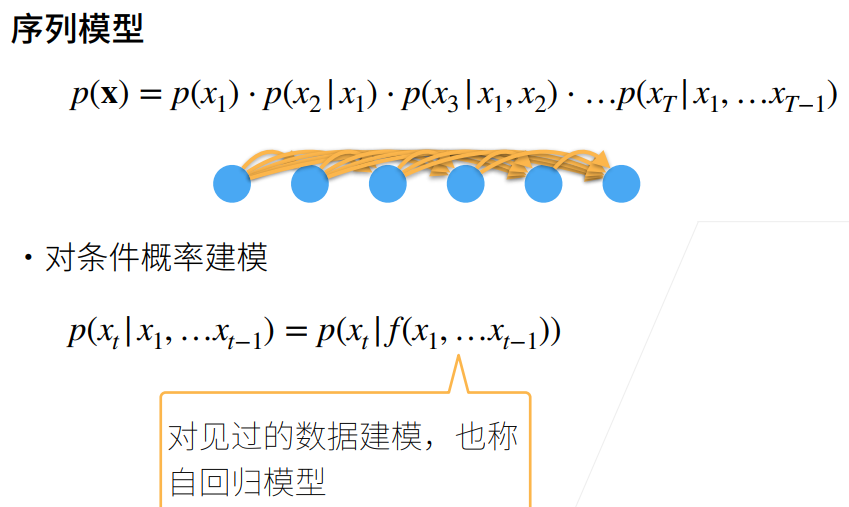

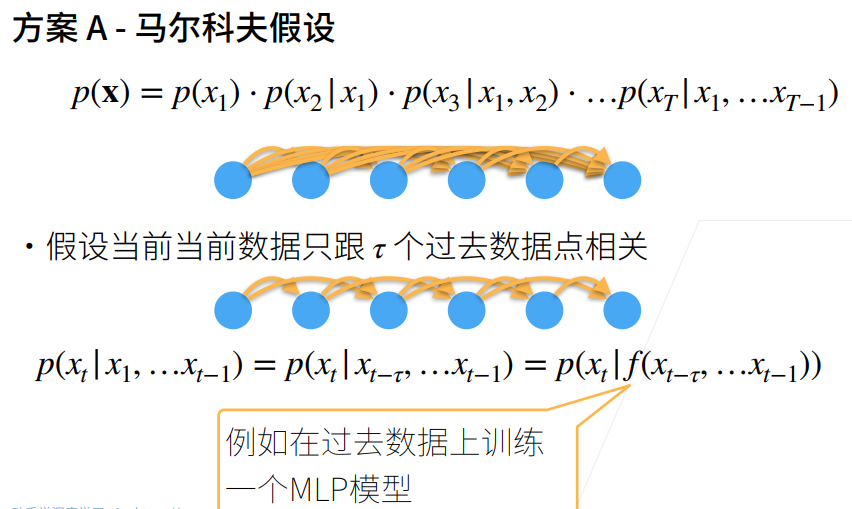

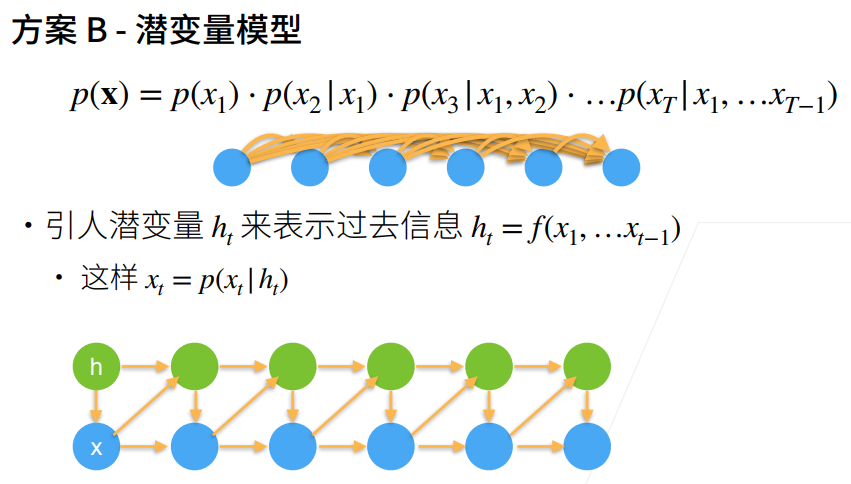

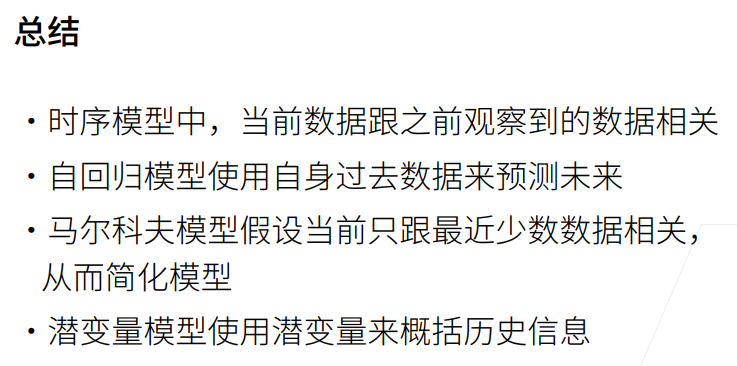

# 2. 序列模型

① 使用正弦函数和一些可加性噪声来生成序列数据，时间步为1,2,...,1000

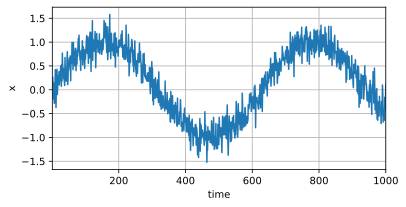

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 总时间步数
T = 1000 
# 创建一个从1到T的张量
time = torch.arange(1, T + 1, dtype = torch.float32) # 1到1000为时间
# 生成频率为0.01的正弦波并加入随机噪声
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# 绘制数据
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize=(6,3))

② 将数据映射为数据对$y_t = x_t$和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$

In [2]:
# 延迟时间步长
tau = 4
# 创建一个形状为(T - tau, tau)的零张量作为特征
features = torch.zeros((T - tau, tau)) # T - tau 为样本数，tau 为特征数
# 每四个数据作为特征，第五个作为标签，不断构造这样的数据形成数据集
for i in range(tau):
    # 每四个数据作为特征，第五个作为标签，不断构造这样的数据形成数据集
    features[:, i] = x[i:T - tau + i]
# 所从第5个时刻开始，每个时刻的label是该时刻的x值，该时刻的输入是前4个时刻的数值组成的一个向量。
# 经过变化后数据的输入共有996组4个一组的数据，输出共996个值
# 提取标签数据并进行形状变换
labels = x[tau:].reshape((-1,1))
# 批量大小和训练样本数量
batch_size, n_train = 16, 600
# 使用 features 和 labels 的前 n_train 个样本创建一个可迭代的训练集
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),
                           batch_size, is_train=True)

③ 使用一个相当简单的结构：只是一个拥有两个全连接层的多层感知机

In [3]:
def init_weights(m):
    # 如果当前模块是线性层
    if type(m) == nn.Linear:
        # 初始化权重函数 
        nn.init.xavier_uniform_(m.weight)
    
def get_net():
    # 定义神经网络结构
    net = nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
    # 对网络的权重进行初始化
    net.apply(init_weights)
    # 返回构建好的神经网络模型
    return net

# 定义均方误差损失函数
loss = nn.MSELoss()

④ 训练模型

In [4]:
def train(net, train_iter, loss, epochs, lr):
    # 定义优化器
    trainer = torch.optim.Adam(net.parameters(), lr)
    # 迭代训练指定的轮数
    for epoch in range(epochs):
        # 遍历训练集中的每个批次
        for X, y in train_iter:
            # 梯度清零
            trainer.zero_grad()
            # 前向传播计算损失
            l = loss(net(X), y)
            # 反向传播求梯度
            l.backward()
            # 更新模型参数
            trainer.step()
        # 打印当前轮次的损失
        print(f'epoch {epoch + 1}, '
             f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

# 创建神经网络模型
net = get_net()
# 训练模型
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.065596
epoch 2, loss: 0.055322
epoch 3, loss: 0.052283
epoch 4, loss: 0.050081
epoch 5, loss: 0.050155


⑤ 模型预测下一个时间步。

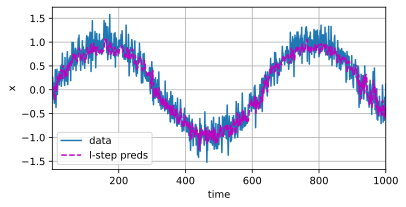

In [5]:
# 对特征进行一步预测
onestep_preds = net(features)
# 进行数据可视化，将真实数据和一步预测结果绘制在同一个图中进行比较
d2l.plot([time, time[tau:]],
        [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
        legend = ['data','l-step preds'], xlim = [1, 1000], figsize=(6,3))   

⑥ 进行多步预测

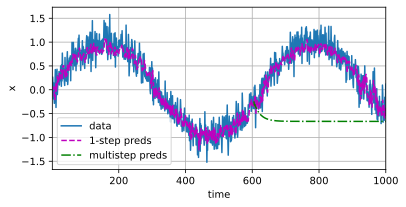

In [6]:
# 初始化多步预测结果的张量
multistep_preds = torch.zeros(T)
# 将已知的真实数据赋值给多步预测结果
multistep_preds[:n_train + tau] = x[:n_train + tau]
# 对剩余时间步进行多步预测
for i in range(n_train + tau, T):
    # 获得多步预测结果
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1)))

# 进行数据可视化
d2l.plot(
    [time, time[tau:], time[n_train + tau:]], 
    [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],        
    'time', 
    'x', 
    legend = ['data', '1-step preds', 'multistep preds'], 
    xlim=[1,1000],
    figsize=(6,3) )  

⑦ 更仔细地看一下k步预测。

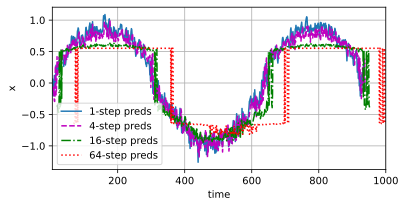

In [7]:
# 最大步长
max_steps = 64
# 初始化特征张量
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 从 0 到 tau-1进行遍历
for i in range(tau):
    # 构造特征矩阵
    features[:, i] = x[i:i + T - tau - max_steps + 1]
    
# 从 tau 到 tau + max_steps - 1，通过 net(features[:, i - tau:i]) 进行多步预测
for i in range(tau, tau + max_steps):
    # 进行多步预测并更新特征矩阵
    features[:,i] = net(features[:, i - tau:i]).reshape(-1)
    
# 预测的步长
steps = (1, 4, 16, 64)
# 进行数据可视化
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
        [features[:, (tau + i - 1)].detach().numpy() for i in steps],
        'time',
        'x',
        legend = [f'{i}-step preds' for i in steps],
        xlim = [5,1000],
        figsize=(6,3) )